In [65]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn


## add your packages ##


# 2D visualization
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap

# metrics
from dcor import distance_correlation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import OneHotEncoder

# clustering
import igraph as ig
import leidenalg as la
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# graph interaction
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

# other
from tqdm import tqdm

## end of ou packages ##

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import black
import jupyter_black

jupyter_black.load(line_length=79)
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("./data")
intermediate_path = Path("../results/intermediate")
plt.style.use("../matplotlib_style.txt")

np.random.seed(42)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [66]:
import os

os.makedirs(data_path, exist_ok=True)
os.makedirs(intermediate_path, exist_ok=True)
os.makedirs(variables_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)

# 0. Data Loading 

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [67]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [68]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [69]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

In [71]:
print("Number of genes:", len(genes))
genes

Number of genes: 42466


array(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', ..., 'n-R5s98',
       'n-TSaga9', 'n-TStga1'], dtype=object)

### Cluster colors

In [72]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [73]:
cluster_colors.shape

(1329,)

In [74]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [75]:
rna_type.shape

(1329,)

In [76]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [77]:
clusterCols = np.array(list(dict_rna_type_colors.values()))
cluster_names = np.array(list(dict_rna_type_colors.keys()))
len(dict_rna_type_colors)

88

### Electrophysiological features

In [78]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [79]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [80]:
np.sum(np.isnan(ephysData_filtered))

0

# 1. Data Inspection


First, to get a feeling for the data at hand, we try to visualize it and compute some statistics...

In [81]:
exonCounts.shape

(1329, 42466)

First we remove all genes from the dataset that do not occur in any of the cells

In [82]:
# test for nans
assert np.sum(np.isnan(exonCounts)) == 0

# kick out genes with no expression
keepgenes = np.sum(exonCounts, axis=0) > 0
exonCounts = exonCounts[:, keepgenes]
genes = genes[keepgenes]
exonLengths = exonLengths[keepgenes]

In [83]:
exonCounts.shape

(1329, 42197)

## 1.1. Compute Statistics

In [84]:
# Compute the average expression for each gene
avg_expr = np.mean(exonCounts, axis=0)
frac_zeros = np.mean(exonCounts == 0, axis=0)

# compute variance
var_expr = np.var(exonCounts, axis=0)

# Compute fano factor
fano_factor = var_expr / avg_expr

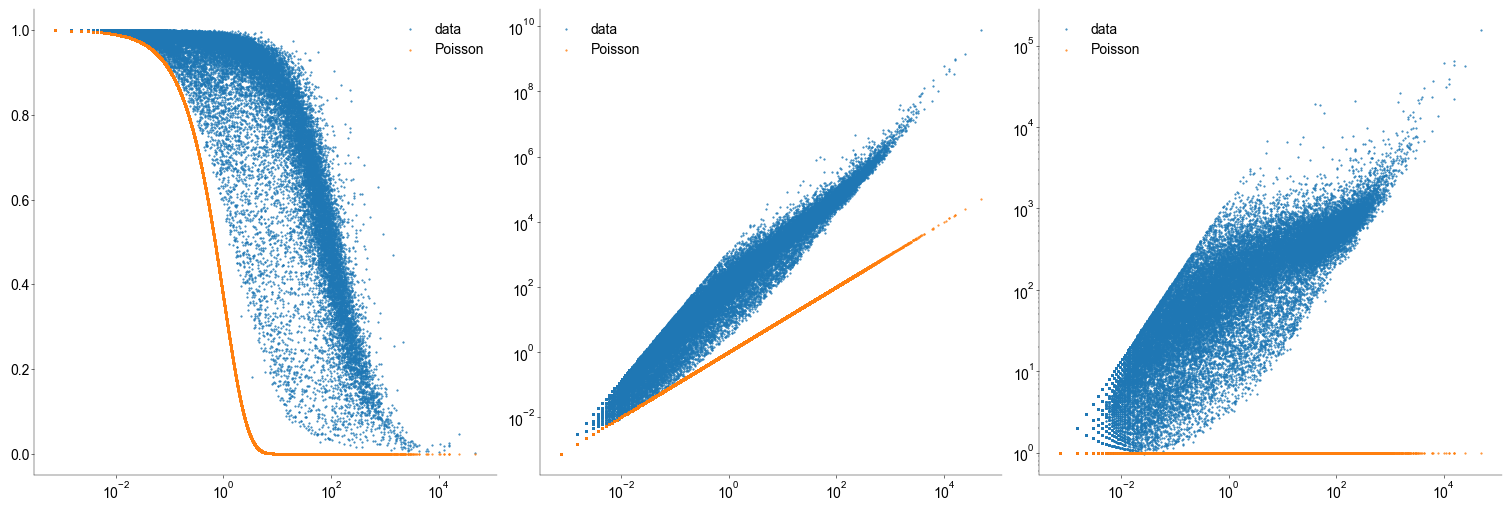

In [85]:
# visualize that the distribution does indeed not follow a poisson distribution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(avg_expr, frac_zeros, s=1, label="data")
axs[0].scatter(avg_expr, np.exp(-avg_expr), s=1, label="Poisson")

axs[1].scatter(avg_expr, var_expr, s=1, label="data")
axs[1].scatter(avg_expr, avg_expr, s=1, label="Poisson")

axs[2].scatter(avg_expr, fano_factor, s=1, label="data")
axs[2].scatter(avg_expr, np.ones_like(avg_expr), s=1, label="Poisson")

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

**Analysis:** We can see what was already given in the task description, i.e. that the data does not follow a Poisson distribution because it is not acquired via UMI.

## 1.2. Histogram of Sequencing Depths

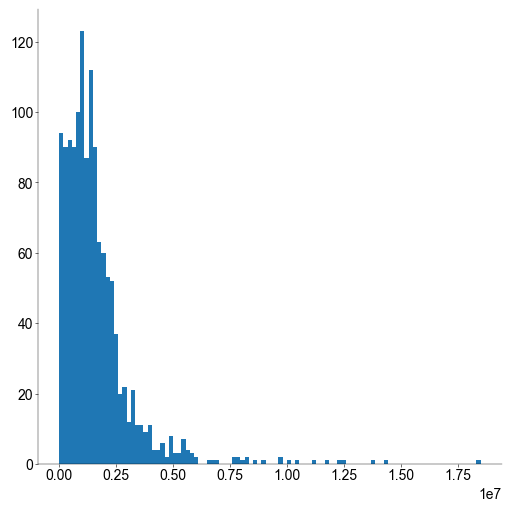

In [86]:
# plot sequencing depth of each cell

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.sum(exonCounts, axis=1), bins=100)

plt.show()

# TODO: why does this look so much different from that in the exercise sheet (esp. x-axis)

## 1.3 Variability

In [87]:
# calculate amount of cells with count of at leats c_min for each gene
c_min = 32
n_cells = np.sum(exonCounts >= c_min, axis=0)
exclude = n_cells < 10

variable_exonCounts = exonCounts[:, ~exclude]
variable_genes = genes[~exclude]
variable_exonLengths = exonLengths[~exclude]

variable_exonCounts.shape, variable_genes.shape, variable_exonLengths.shape

((1329, 18210), (18210,), (18210,))

In [88]:
# compute the mean log2 count across all counts that are larger than c_min
high_counts = variable_exonCounts > c_min

mu = np.array(
    [
        np.log2(variable_exonCounts[high_counts[:, i], i]).mean()
        for i in range(variable_exonCounts.shape[1])
    ]
)
# compute the the fraction of counts that are smaller than or equal to c_min
theta = (variable_exonCounts < c_min).mean(axis=0)

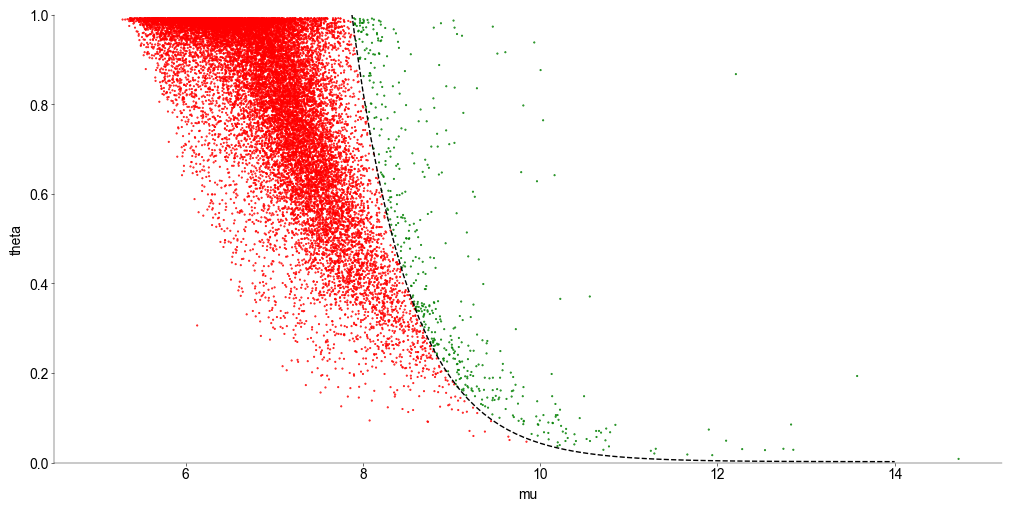

The calculated value for offset is ~11.81 to ensure the number of genes above the boundary to be 500


In [89]:
mu_space = np.linspace(5, 14, 100)


# TODO this is taken from the dataset paper, but it does not resemble the actual data
def boundary(mu, offset):
    return np.exp(-1.5 * mu + offset) + 0.002


def binary_search(mu, target_num_genes):
    """
    Binary search for the optimal value of theta
    """
    offset_min = 0
    offset_max = 1000
    offset = (offset_min + offset_max) / 2
    num_genes = np.sum(theta > boundary(mu, offset))
    while num_genes != target_num_genes:
        if num_genes < target_num_genes:
            offset_max = offset
        else:
            offset_min = offset
        offset = (offset_min + offset_max) / 2
        num_genes = np.sum(theta > boundary(mu, offset))
    return offset, theta > boundary(mu, offset), num_genes


offset, keep_genes, num_genes = binary_search(mu, 500)


boundary_colors = np.array(["red", "green"])[
    (theta > boundary(mu, offset)).astype(int)
]

# plot mu vs theta
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(mu, theta, s=1, c=boundary_colors)
ax.set_xlabel("mu")
ax.set_ylabel("theta")
# ax.set_xlim([0, 1e4])
ax.set_ylim([0, 1])
ax.plot(mu_space, boundary(mu_space, offset), color="black", linestyle="--")
plt.show()


print(
    f"The calculated value for offset is ~{offset:.2f} to ensure the number of genes above the boundary to be {num_genes}"
)

In [90]:
variable_exonCounts = variable_exonCounts[:, keep_genes]
variable_genes = variable_genes[keep_genes]
variable_exonLengths = variable_exonLengths[keep_genes]

variable_exonCounts.shape, variable_genes.shape, variable_exonLengths.shape

((1329, 500), (500,), (500,))

In [91]:
# hacky overwrite of exon counts
# TODO delete

exonCounts = variable_exonCounts
genes = variable_genes
exonLengths = variable_exonLengths

# 2. Data Normalization and Transformation

In the following section we .... bliblablub




## 2.1. Like in the Exercise Sheet

In [92]:
# first we normalize equivalently to what we did in the exercise sheet
norm_counts = (
    exonCounts
    / np.sum(exonCounts, axis=1)[:, None]
    * np.median(np.sum(exonCounts, axis=1))
)
mean_norm_counts = np.mean(norm_counts, axis=0)
var_norm_counts = np.var(norm_counts, axis=0)
fano_norm_counts = var_norm_counts / mean_norm_counts

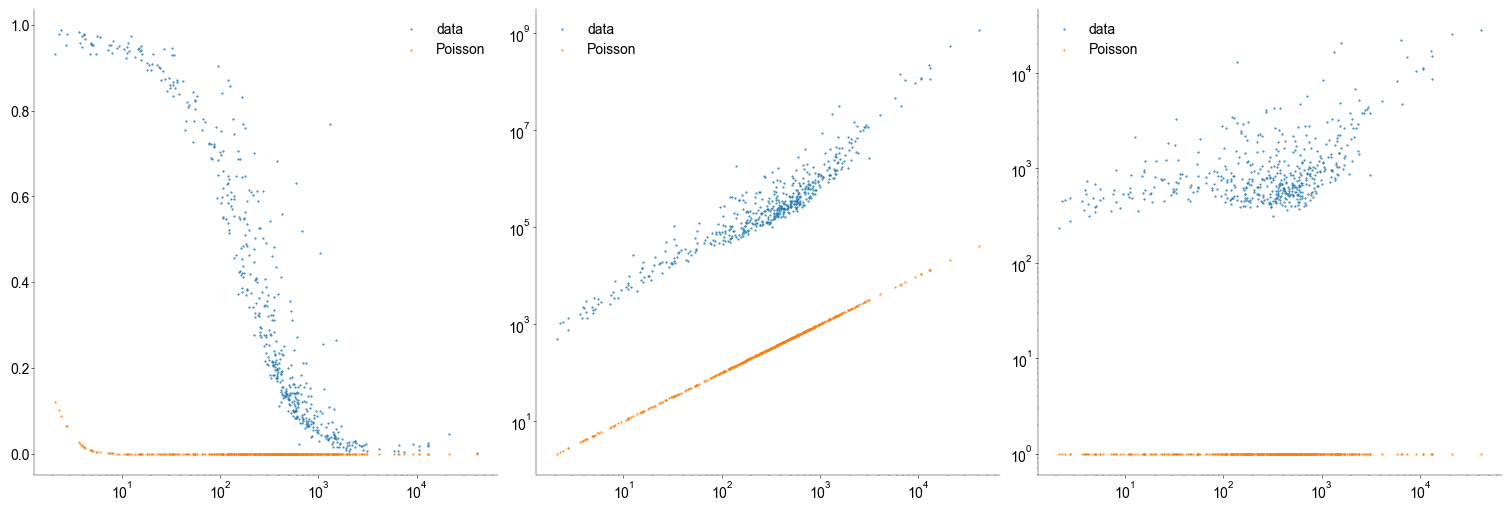

In [93]:
# produce similar plot as above
frac_zeros = np.mean(exonCounts == 0, axis=0)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(mean_norm_counts, frac_zeros, s=1, label="data")
axs[0].scatter(
    mean_norm_counts, np.exp(-mean_norm_counts), s=1, label="Poisson"
)

axs[1].scatter(mean_norm_counts, var_norm_counts, s=1, label="data")
axs[1].scatter(mean_norm_counts, mean_norm_counts, s=1, label="Poisson")

axs[2].scatter(mean_norm_counts, fano_norm_counts, s=1, label="data")
axs[2].scatter(
    mean_norm_counts, np.ones_like(mean_norm_counts), s=1, label="Poisson"
)

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

In [94]:
raw_counts_gr_three = norm_counts[:, fano_norm_counts > 3]

raw_counts_log = np.log(raw_counts_gr_three + 1)  # + 1 to avoid log(0)
raw_counts_sqrt = np.sqrt(raw_counts_gr_three)

## 2.2. Counts per million

In [95]:
from bioinfokit.analys import norm, get_data

In [96]:
# convert exonCounts to dataframe
df = pd.DataFrame(exonCounts.T, columns=cells, index=genes)

In [97]:
nm = norm()
nm.cpm(df)

cpm_df = nm.cpm_norm

In [98]:
cpm_counts = cpm_df.values.T
cpm_counts_log = np.log(cpm_counts + 1)  # + 1 to avoid log(0)
cpm_counts_sqrt = np.sqrt(cpm_counts)

## 2.3. RPKM


In [99]:
# add column with lengths to df
df["length"] = exonLengths
df.head()

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3,length
4930519F16Rik,4368,180,1802,6,479,256,2154,1355,1,772,...,1016,747,211,0,142,1104,184,0,0,3067
9130023H24Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3574
Abat,2514,24,5,1361,62,2044,1,343,31,229,...,878,0,0,0,77,4703,0,0,380,7748
Abcc2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8532
Actb,15011,4819,57490,7423,2034,12717,27046,27059,169,11124,...,5585,6833,601,1005,162,6302,529,2746,1218,2679


In [100]:
nm = norm()
nm.rpkm(df=df, gl="length")
rpkm_df = nm.rpkm_norm

In [101]:
rpkm_counts = rpkm_df.values.T
rpkm_counts_log = np.log(rpkm_counts + 1)  # + 1 to avoid log(0)
rpkm_counts_sqrt = np.sqrt(rpkm_counts)

# 3. Two-dimensional Visualization

we now compile a dict of all normalized counts (with and without transformations) and then Visualize them with different 2D Visualiation methods

**Erklärung**

Hier packe ich alles in das dict format, das ich das komplette notebook lang benutze  
struktur:
- normalizer  
  - transformation  

Später nehm ich einzelne Keys raus, aber die struktur bleibt

In [102]:
# TODO maybe change counts to more appropriate name e.g. raw_counts? - will be used in plotting title
count_dict = {
    "raw": {
        "counts": raw_counts_gr_three,
        "log": raw_counts_log,
        "sqrt": raw_counts_sqrt,
    },
    "cpm": {
        "counts": cpm_counts,
        "log": cpm_counts_log,
        "sqrt": cpm_counts_sqrt,
    },
    "rpkm": {
        "counts": rpkm_counts,
        "log": rpkm_counts_log,
        "sqrt": rpkm_counts_sqrt,
    },
}
num_norms = len(count_dict.keys())
num_transforms = len(count_dict["raw"].keys())

In [103]:
def plot_2d_vis(results, title, clusters=None):
    # plot t-SNE
    num_rows = len(results.keys())
    num_cols = len(list(results.values())[0].keys())
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        figsize=(num_cols * 5, num_rows * 5),
    )
    if axs.ndim == 1:
        axs = axs.reshape(-1, 1)

    fig.suptitle(title, fontsize=25)
    for i, (norm_key, sub_dict) in enumerate(results.items()):
        for j, (trans_key, result) in enumerate(sub_dict.items()):
            axs[i, j].scatter(
                result[:, 0],
                result[:, 1],
                s=7,
                c=cluster_colors
                if clusters is None
                else clusters[norm_key][trans_key],
                cmap="tab20" if clusters is not None else None,
            )
            axs[i, j].set_title(f"{norm_key} {trans_key}".title())
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

## 3.1 Qualitative Assessment

### 3.1.1 PCA


first, as a baseline we will perform PCA and visualize the first two components

In [104]:
# perform PCA
pca = PCA(n_components=50)
pca_results = dict()
for norm_key, sub_dict in count_dict.items():
    pca_results[norm_key] = dict()
    for trans_key, counts in sub_dict.items():
        pca_results[norm_key][trans_key] = pca.fit_transform(counts)

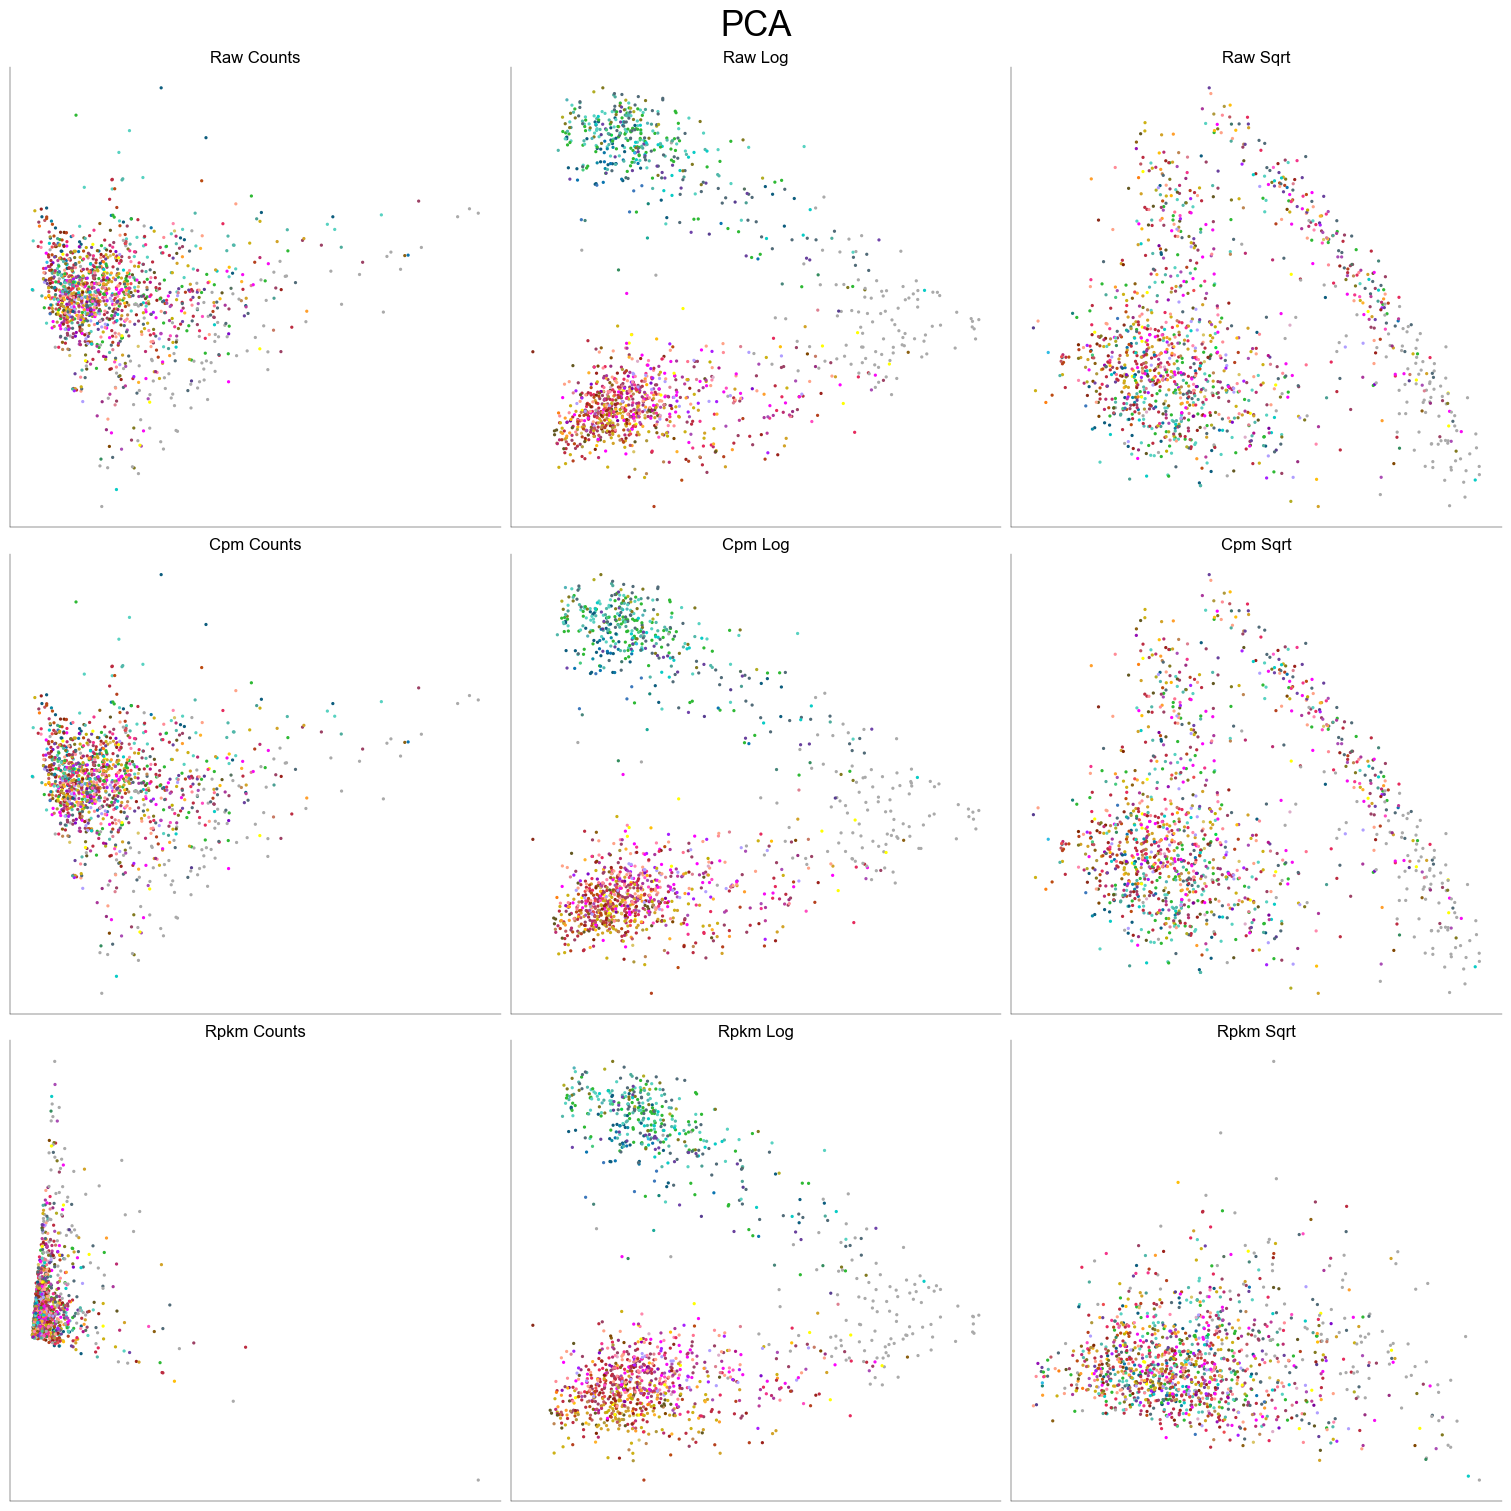

In [105]:
plot_2d_vis(pca_results, "PCA")

#### TODO analysis

### 3.1.2 t-SNE

In [106]:
def plot_tsne(perplexity, exaggeration, interactive=True):
    # display loading bar
    if interactive:
        loading_bar = widgets.IntProgress(
            value=0,
            min=0,
            max=num_norms * num_transforms,
            description="Loading data",
            bar_style="",
            style={"bar_color": "green"},
            orientation="horizontal",
        )
        display(loading_bar)

    # perform t-SNE of PCA results
    exaggeration = exaggeration if exaggeration else None
    tsne = TSNE(perplexity=perplexity, exaggeration=exaggeration)
    tsne_results = dict()
    for norm_key, sub_dict in pca_results.items():
        tsne_results[norm_key] = dict()
        for trans_key, result in sub_dict.items():
            tsne_results[norm_key][trans_key] = tsne.fit(result)
            if interactive:
                loading_bar.value += 1

    plot_2d_vis(tsne_results, "t-SNE")

    if not interactive:
        return tsne_results


perplexity_box = widgets.BoundedIntText(value=20, min=1, max=1000, step=10)
exaggeration_box = widgets.BoundedIntText(value=1, min=0, max=1000)
# TODO uncomment
# interact(
#     plot_tsne,
#     perplexity=perplexity_box,
#     exaggeration=exaggeration_box,
#     interactive=True,
# )

**NOTES** 
- the higher perplexity, the longer loading time
- if plot shows multiple times, reload window

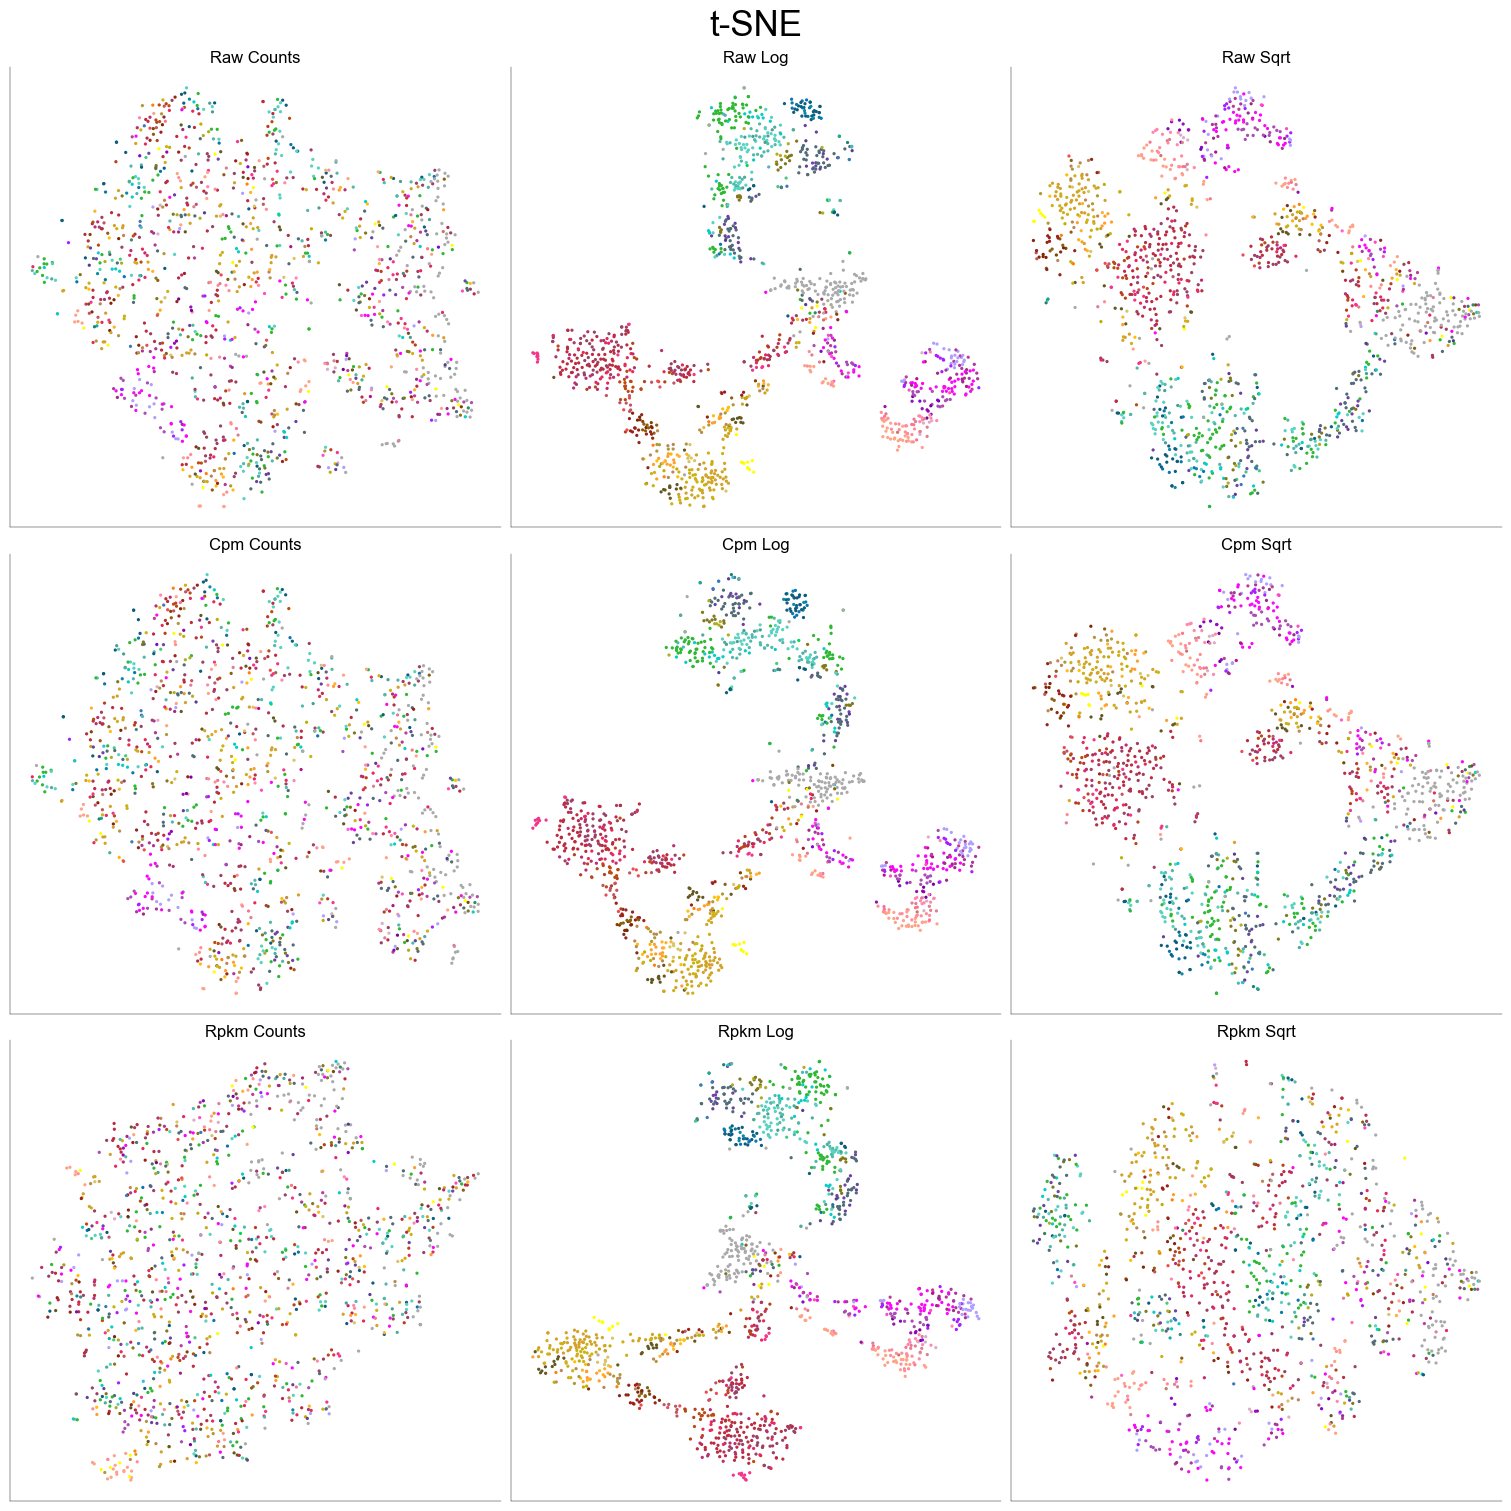

In [107]:
tsne_results = plot_tsne(33, 0, interactive=False)  # TODO insert chosen values

### 3.1.3 UMAP

In [108]:
umap_func = umap.UMAP()
umap_results = dict()
for norm_key, sub_dict in pca_results.items():
    umap_results[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        umap_results[norm_key][trans_key] = umap_func.fit_transform(pca_result)

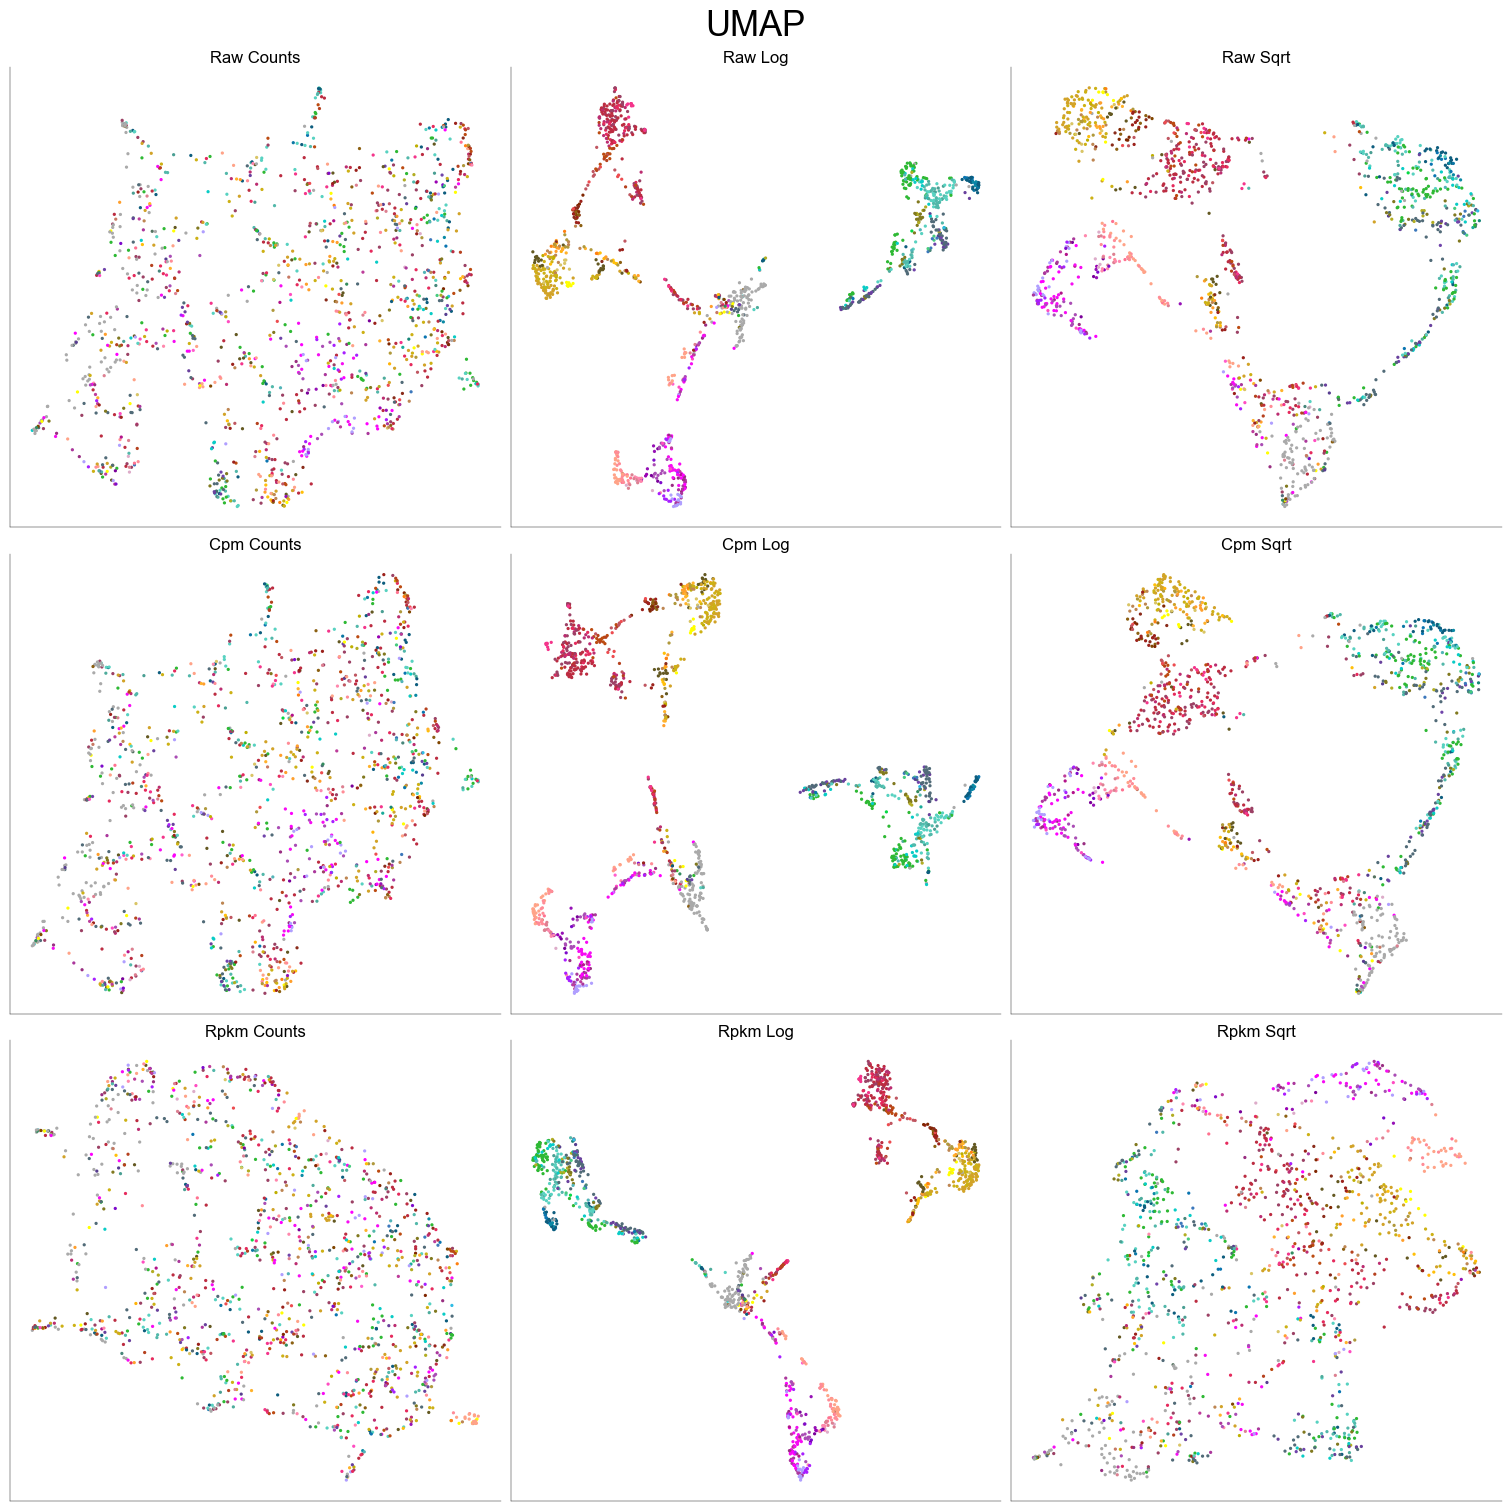

In [109]:
plot_2d_vis(umap_results, "UMAP")

## 3.2 Quantitative Analysis

From the qualitative (visual) inspection in the previous section, we can see that the untransformed data (first column) does not provide a good base for clustering or 2D visualization, thus we remove that column entirely for further analysis

**Erklärung**

hier haue ich alles außer "log" und "cpm", "rpkm" raus

In [110]:
result_dicts = [pca_results, tsne_results, umap_results]

remove_norms = ["raw"]  # ["raw", "cpm", "rpkm"]
remove_transforms = ["counts", "sqrt"]  # ["counts", "log", "sqrt"]

for result_dict in result_dicts:
    for norm in remove_norms:
        try:
            del result_dict[norm]
        except KeyError:
            pass

for result_dict in result_dicts:
    for norm_key, sub_dict in result_dict.items():
        for trans in remove_transforms:
            try:
                del sub_dict[trans]
            except KeyError:
                pass

for result_dict in result_dicts:
    print(result_dict.keys())
    for norm_key, sub_dict in result_dict.items():
        print(sub_dict.keys())

dict_keys(['cpm', 'rpkm'])
dict_keys(['log'])
dict_keys(['log'])
dict_keys(['cpm', 'rpkm'])
dict_keys(['log'])
dict_keys(['log'])
dict_keys(['cpm', 'rpkm'])
dict_keys(['log'])
dict_keys(['log'])


### 3.2.1 Distance Correlation

In [111]:
pca_dc = dict()
for norm_key, sub_dict in pca_results.items():
    pca_dc[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        pca_dc[norm_key][trans_key] = distance_correlation(
            pca_result, pca_result[:, :2]
        )

tsne_dc = dict()
for norm_key, sub_dict in pca_results.items():
    tsne_dc[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        tsne_dc[norm_key][trans_key] = distance_correlation(
            pca_result, tsne_results[norm_key][trans_key]
        )

umap = dict()
for norm_key, sub_dict in pca_results.items():
    umap[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        umap[norm_key][trans_key] = distance_correlation(
            pca_result, umap_results[norm_key][trans_key]
        )

print(f"PCA distance correlations: {pca_dc}")
print(f"t-SNE distance correlations: {tsne_dc}")
print(f"UMAP distance correlations: {umap}")

PCA distance correlations: {'cpm': {'log': 0.9368057617702895}, 'rpkm': {'log': 0.9257353790367905}}
t-SNE distance correlations: {'cpm': {'log': 0.7603648522759532}, 'rpkm': {'log': 0.745153383508992}}
UMAP distance correlations: {'cpm': {'log': 0.7579123884009795}, 'rpkm': {'log': 0.7528490690078592}}


### 3.2.2 KNN accuracy

In [112]:
str_rna_types = np.array([str(r) for r in rna_type])

**Erklärung**

get_knn_score ist die funktion, die die eigenltiche score ausgibt, gegeben der input matrix und den gt labels  
print_knn_scores macht das ganze dann für alle einträge in einem dict und printet das dict noch aus

In [113]:
# TODO is this what they meant?
def get_knn_score(input, gt_labels=str_rna_types):
    max_accuracy = 0
    for neighbor in range(1, 30):
        knn = KNeighborsClassifier(n_neighbors=neighbor)
        X_train, X_test, y_train, y_test = train_test_split(
            input, gt_labels, random_state=42
        )
        knn.fit(X_train, y_train)
        prediction = knn.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_neighbor = neighbor
    return best_neighbor, max_accuracy

    # Note that the recall of the knn classifier is the same as the accuracy, for any of the averaging mode, as recall is a binary metric
    return [
        accuracy_score(y_test, prediction),
        recall_score(y_test, prediction, average="micro"),
    ]


def print_knn_scores(result_dict, title, f=lambda x: x):
    out_dict = dict()
    for norm_key, sub_dict in result_dict.items():
        out_dict[norm_key] = dict()
        for trans_key, pca_result in sub_dict.items():
            out_dict[norm_key][trans_key] = dict()
            out_dict[norm_key][trans_key].update(
                zip(
                    ["num_neighbors", "accuracy"],
                    get_knn_score(f(pca_result)),
                )
            )

    print(f"{title} knn accuracy/recall: {out_dict}")
    return out_dict


print(
    "Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric\n"
)
high_dim_knn_score = print_knn_scores(pca_results, "PCA")
pca_knn_score = print_knn_scores(pca_results, "PCA 2D", lambda x: x[:, :2])
tsne_knn_score = print_knn_scores(tsne_results, "t-SNE")
umap_knn_score = print_knn_scores(umap_results, "UMAP")

Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric

PCA knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 8, 'accuracy': 0.5255255255255256}}, 'rpkm': {'log': {'num_neighbors': 5, 'accuracy': 0.5135135135135135}}}
PCA 2D knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 22, 'accuracy': 0.2012012012012012}}, 'rpkm': {'log': {'num_neighbors': 11, 'accuracy': 0.2072072072072072}}}
t-SNE knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 4, 'accuracy': 0.5225225225225225}}, 'rpkm': {'log': {'num_neighbors': 4, 'accuracy': 0.4954954954954955}}}
UMAP knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 8, 'accuracy': 0.4894894894894895}}, 'rpkm': {'log': {'num_neighbors': 9, 'accuracy': 0.4624624624624625}}}


To achieve comparability in terms of the 2D respresentation, we calculate the accuracy score of the respective 2D representation divided by the knn accuracy 50-dimensional PCA respresentation over the thus normailizing it to the $[0, 1]$ interval

In [114]:
def normalize_knn_scores(scores):
    out_dict = dict()
    for norm_key, sub_dict in scores.items():
        out_dict[norm_key] = dict()
        for trans_key, score in sub_dict.items():
            out_dict[norm_key][trans_key] = (
                score["accuracy"]
                / high_dim_knn_score[norm_key][trans_key]["accuracy"]
            )

    return out_dict


print(f"PCA 2D knn normalized accuracy: {normalize_knn_scores(pca_knn_score)}")
print(f"t-SNE knn normalized accuracy: {normalize_knn_scores(tsne_knn_score)}")
print(f"UMAP knn normalized accuracy: {normalize_knn_scores(umap_knn_score)}")

PCA 2D knn normalized accuracy: {'cpm': {'log': 0.3828571428571428}, 'rpkm': {'log': 0.4035087719298246}}
t-SNE knn normalized accuracy: {'cpm': {'log': 0.9942857142857142}, 'rpkm': {'log': 0.9649122807017544}}
UMAP knn normalized accuracy: {'cpm': {'log': 0.9314285714285714}, 'rpkm': {'log': 0.9005847953216375}}


### 3.2.3 Combination

Now that we have two scores that are both in the interval $[0, 1]$ we can combine them, to create an even more informed score

In [115]:
def get_combined_score(high_dim_matrix, low_dim_matrix):
    _, high_dim_accuracy = get_knn_score(high_dim_matrix)
    _, accuracy = get_knn_score(low_dim_matrix)
    dc = distance_correlation(high_dim_matrix, low_dim_matrix)
    return np.mean([accuracy / high_dim_accuracy, dc])


def get_all_combined_scores(result_dict, f=lambda x: x):
    out_dict = dict()
    for norm_key, sub_dict in result_dict.items():
        out_dict[norm_key] = dict()
        for trans_key, result in sub_dict.items():
            out_dict[norm_key][trans_key] = get_combined_score(
                pca_results[norm_key][trans_key], f(result)
            )

    return out_dict


print(
    f"PCA 2D combined score: {get_all_combined_scores(pca_results, lambda x: x[:, :2])}"
)
print(f"t-SNE combined score: {get_all_combined_scores(tsne_results)}")
print(f"UMAP combined score: {get_all_combined_scores(umap_results)}")

PCA 2D combined score: {'cpm': {'log': 0.6598314523137161}, 'rpkm': {'log': 0.6646220754833075}}
t-SNE combined score: {'cpm': {'log': 0.8773252832808337}, 'rpkm': {'log': 0.8550328321053732}}
UMAP combined score: {'cpm': {'log': 0.8446704799147755}, 'rpkm': {'log': 0.8267169321647483}}


### 3.2.4 Optimization of t-SNE hyperparameters

Now we optimize the tsne hyperparameters perplexity and exaggeration wrt. distance correlation

**Erklärung**

tsne_gridsearch führt ein gridsearch über tsne gegeben einer input_matrix und metric durch und gibt dann dass results und die hyperparameter von dem besten gefundenen aus

die Zelle danach legt die hyperparameterspaces fest und mach einen gridsearch für alle high-dim pca matrizen im dict  
hier werden dann in dem tsne_resluts dict tsnes mit verschiedenen Hyperparams gespeichert!!

In [116]:
def tsne_gridsearch(
    pca_result, perplexity_space, exaggeration_space, metric, progress_bar=None
):
    max_score = 0
    for perplexity in perplexity_space:
        for exaggeration in exaggeration_space:
            tsne = TSNE(
                perplexity=perplexity,
                exaggeration=None if exaggeration == 0 else exaggeration,
            )
            tsne_result = tsne.fit(pca_result)
            score = metric(pca_result, tsne_result)
            if score > max_score:
                max_score = score
                best_perplexity = perplexity
                best_exaggeration = exaggeration
                best_result = tsne_result
            if progress_bar is not None:
                progress_bar.update(1)
    return best_result, max_score, best_perplexity, best_exaggeration

In [474]:
# WARNING this cell takes a significant amount of time to run (4h on my machine)
# you can skip the execution and thake the results from the next cell

# maximum perplexity imposed by t-SNE
# (giving a perplexity higher than this will result in using this number regardless)
max_perplexity = (
    int(list(list(pca_results.values())[0].values())[0].shape[0] / 3) - 1
)

# for the following, we choose a more realistic maximum perplexity to reduce runtime
max_perplexity = 50

# search spaces
perplexity_space = np.linspace(1, max_perplexity, 10, dtype=int)
exaggeration_space = np.linspace(0, 4, 4, dtype=int)

tsne_results = dict()
tsne_dc = dict()
tsne_hyperparams = dict()
progress_bar = tqdm(
    total=perplexity_space.shape[0]
    * exaggeration_space.shape[0]
    * len(pca_results.items())
    * len(list(pca_results.values())[0].items())
)
for norm_key, sub_dict in pca_results.items():
    tsne_results[norm_key] = dict()
    tsne_dc[norm_key] = dict()
    tsne_hyperparams[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        (
            tsne_results[norm_key][trans_key],
            tsne_dc[norm_key][trans_key],
            tsne_hyperparams[norm_key]["perplexity"],
            tsne_hyperparams[norm_key]["exaggeration"],
        ) = tsne_gridsearch(
            pca_result,
            perplexity_space,
            exaggeration_space,
            get_combined_score,
            progress_bar,
        )
        time.sleep(1)
progress_bar.close()

# save results
pickle_out = open(intermediate_path / "tsne_results.pkl", "wb")
pickle.dump((tsne_results, tsne_dc, tsne_hyperparams), pickle_out)
pickle_out.close()

100%|██████████| 80/80 [09:50<00:00,  7.38s/it]


In [44]:
# load results
pickle_in = open(intermediate_path / "tsne_results.pkl", "rb")
tsne_results, tsne_dc, tsne_hyperparams = pickle.load(pickle_in)
pickle_in.close()

In [475]:
# plot_2d_vis(tsne_results, "t-SNE")
tsne_dc, tsne_hyperparams

({'cpm': {'log': 0.8877714310848848}, 'rpkm': {'log': 0.8848930879363668}},
 {'cpm': {'perplexity': 6, 'exaggeration': 2},
  'rpkm': {'perplexity': 22, 'exaggeration': 1}})

Now  we can reevaluate the combined score of the tsne result:

In [476]:
print(
    f"PCA 2D combined score: {get_all_combined_scores(pca_results, lambda x: x[:, :2])}"
)
print(f"t-SNE combined score: {get_all_combined_scores(tsne_results)}")
print(f"UMAP combined score: {get_all_combined_scores(umap_results)}")

PCA 2D combined score: {'cpm': {'log': 0.6598314523137161}, 'rpkm': {'log': 0.6646220754833075}}
t-SNE combined score: {'cpm': {'log': 0.8877714310848848}, 'rpkm': {'log': 0.8848930879363668}}
UMAP combined score: {'cpm': {'log': 0.8484533780537105}, 'rpkm': {'log': 0.8064359340830262}}


# 4. Clustering

## 4.1 K-Means

In [477]:
_, counts = np.unique(cluster_colors, return_counts=True)

n_clusters = np.sum(counts > c_min)
n_clusters = 10  # TODO choose a proper number of clusters
print(f"Number of clusters: {n_clusters}")
k_means_labels = dict()
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
for norm_key, sub_dict in pca_results.items():
    k_means_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        k_means_labels[norm_key][trans_key] = kmeans.fit_predict(pca_result)

Number of clusters: 10


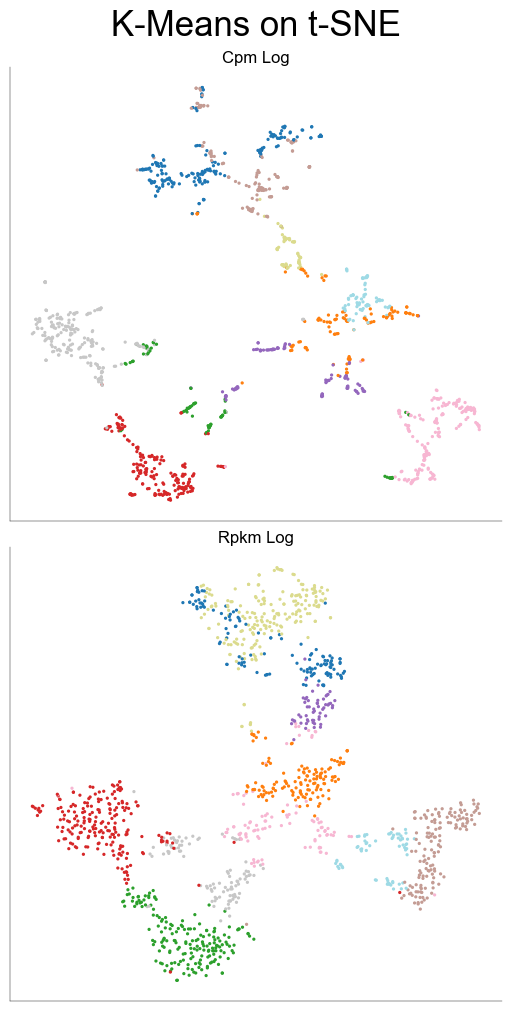

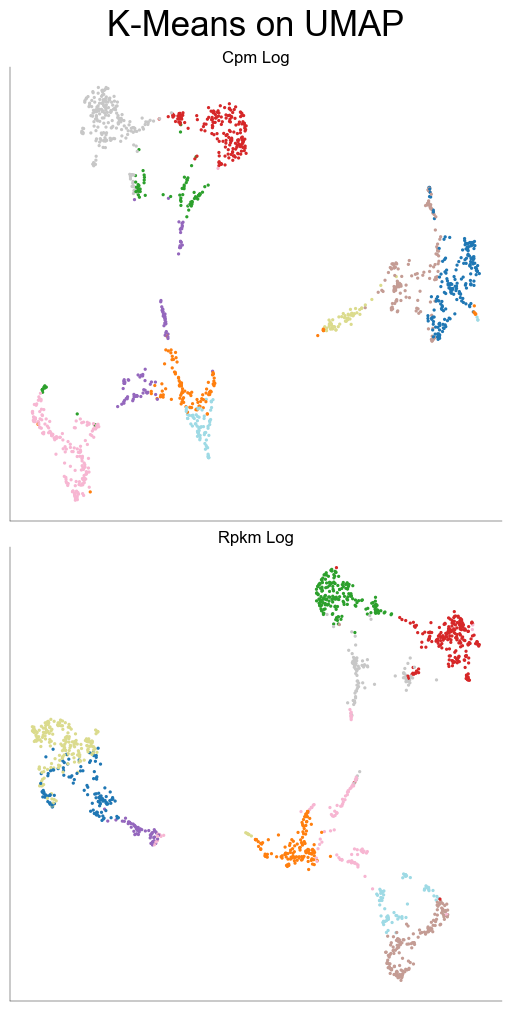

In [478]:
plot_2d_vis(tsne_results, "K-Means on t-SNE", k_means_labels)
plot_2d_vis(umap_results, "K-Means on UMAP", k_means_labels)

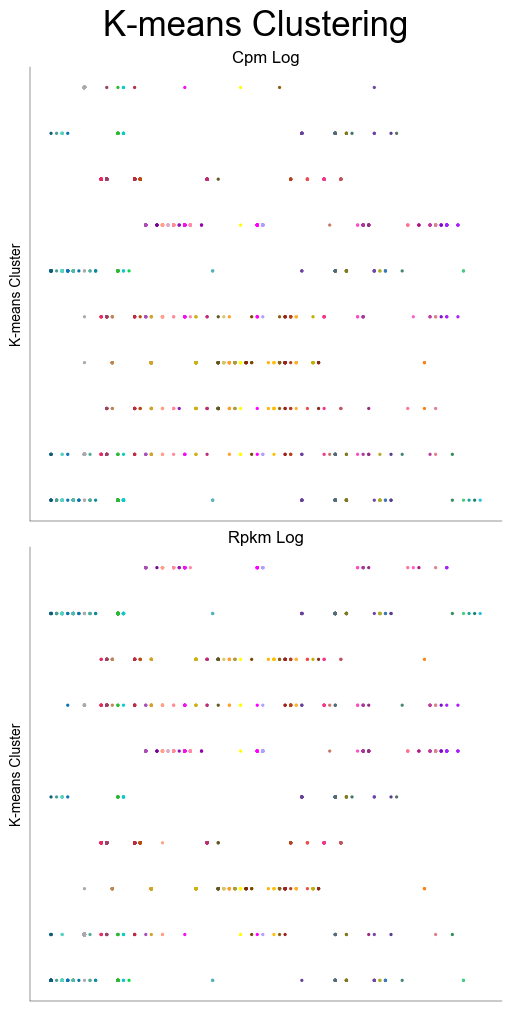

In [479]:
# plot actual categories vs k-means clusters
num_rows = len(k_means_labels.keys())
num_cols = len(list(k_means_labels.values())[0].keys())
fig, axs = plt.subplots(
    num_rows,
    num_cols,
    figsize=(num_cols * 5, num_rows * 5),
)


if axs.ndim == 1:
    axs = axs.reshape(-1, 1)

fig.suptitle("K-means Clustering", fontsize=25)
for i, (norm_key, sub_dict) in enumerate(k_means_labels.items()):
    for j, (trans_key, pca_result) in enumerate(sub_dict.items()):
        axs[i, j].scatter(
            cluster_colors,
            pca_result,
            s=7,
            c=cluster_colors,
        )
        axs[i, j].set_title(f"{norm_key} {trans_key}".title())
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        if i == num_transforms - 1:
            axs[i, j].set_xlabel("GT Cluster")
        if j == 0:
            axs[i, j].set_ylabel("K-means Cluster")

## 4.2 Leiden Clustering

In [480]:
leiden_partition = dict()
leiden_labels = dict()
for norm_key, sub_dict in pca_results.items():
    leiden_partition[norm_key] = dict()
    leiden_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        A = kneighbors_graph(pca_result, 15)
        sources, targets = A.nonzero()
        g = ig.Graph(directed=False)
        g.add_vertices(A.shape[0])
        g.add_edges(list(zip(sources, targets)))
        leiden_partition[norm_key][trans_key] = la.find_partition(
            g, la.RBConfigurationVertexPartition
        )
        leiden_labels[norm_key][trans_key] = leiden_partition[norm_key][
            trans_key
        ].membership

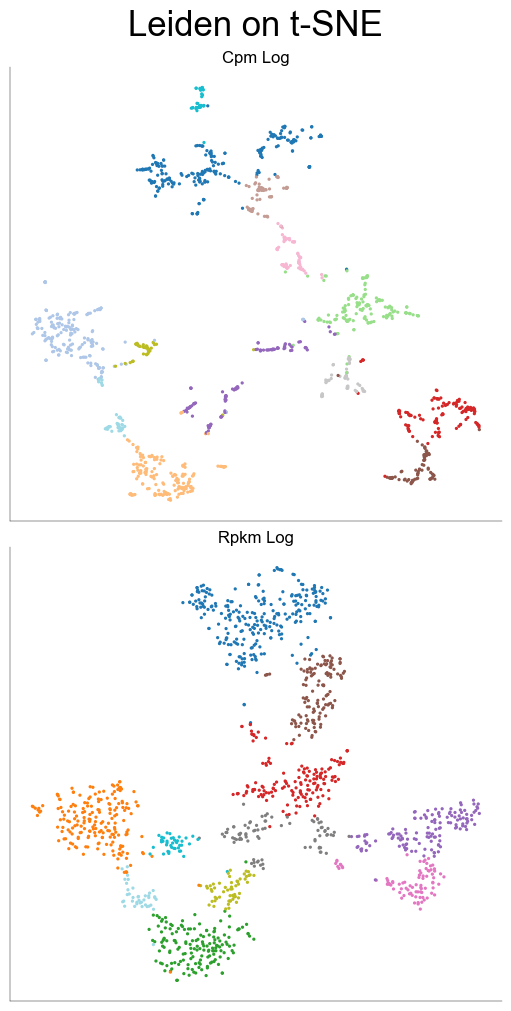

In [482]:
plot_2d_vis(tsne_results, "Leiden on t-SNE", leiden_labels)

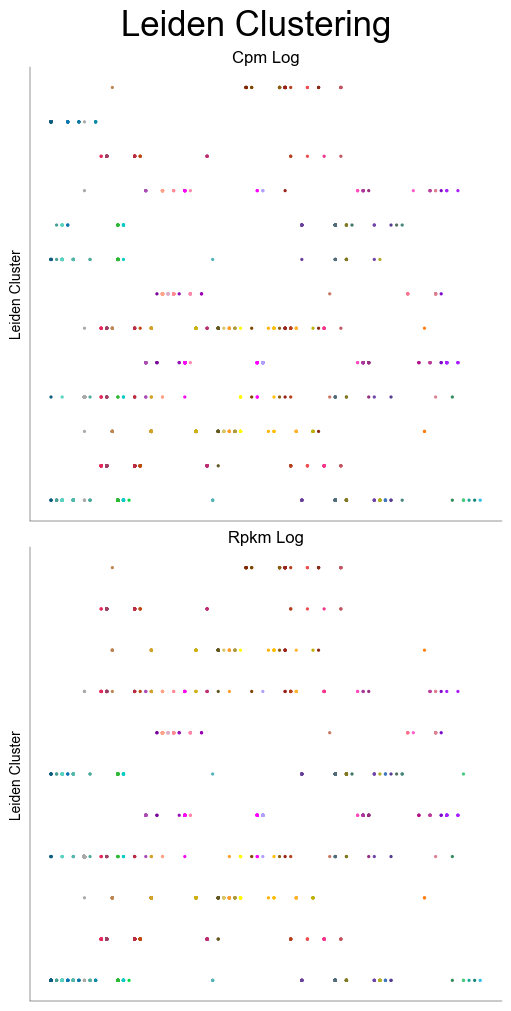

In [483]:
# plot actual categories vs leiden clusters
num_rows = len(leiden_partition.keys())
num_cols = len(list(leiden_partition.values())[0].keys())
fig, axs = plt.subplots(
    num_rows,
    num_cols,
    figsize=(num_cols * 5, num_rows * 5),
)


if axs.ndim == 1:
    axs = axs.reshape(-1, 1)

fig.suptitle("Leiden Clustering", fontsize=25)
for i, (norm_key, sub_dict) in enumerate(leiden_partition.items()):
    for j, (trans_key, pca_result) in enumerate(sub_dict.items()):
        axs[i, j].scatter(
            cluster_colors,
            pca_result.membership,
            s=7,
            c=cluster_colors,
        )
        axs[i, j].set_title(f"{norm_key} {trans_key}".title())
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        if i == num_transforms - 1:
            axs[i, j].set_xlabel("GT Cluster")
        if j == 0:
            axs[i, j].set_ylabel("Leiden Cluster")

**Current Analysis:** NO CORRELATION between ground truth labels and cluster result

## 4.3 GMM

In [117]:
def gmm_choose_n_clusters(X: np.ndarray, max_clusters: int = 10):
    min_bic = np.inf
    for n_clusters in range(1, max_clusters + 1):
        gmm = GaussianMixture(n_components=n_clusters)
        gmm.fit(X)
        bic = gmm.bic(X)
        if bic < min_bic:
            min_bic = bic
            best_n_clusters = n_clusters
            best_gmm = gmm
    print(f"Best result: {best_n_clusters} clusters, BIC = {min_bic}")
    return best_n_clusters, best_gmm.predict(X)

In [120]:
_, counts = np.unique(cluster_colors, return_counts=True)

max_n_clusters = np.sum(counts > 0)

print(f"Maximum number of clusters: {max_n_clusters}")
gmm_labels = dict()
for norm_key, sub_dict in pca_results.items():
    gmm_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        _, gmm_labels[norm_key][trans_key] = gmm_choose_n_clusters(
            pca_result, max_n_clusters
        )

Maximum number of clusters: 78
Best result: 66 clusters, BIC = 371797.5691343084
Best result: 58 clusters, BIC = 353155.9952995572


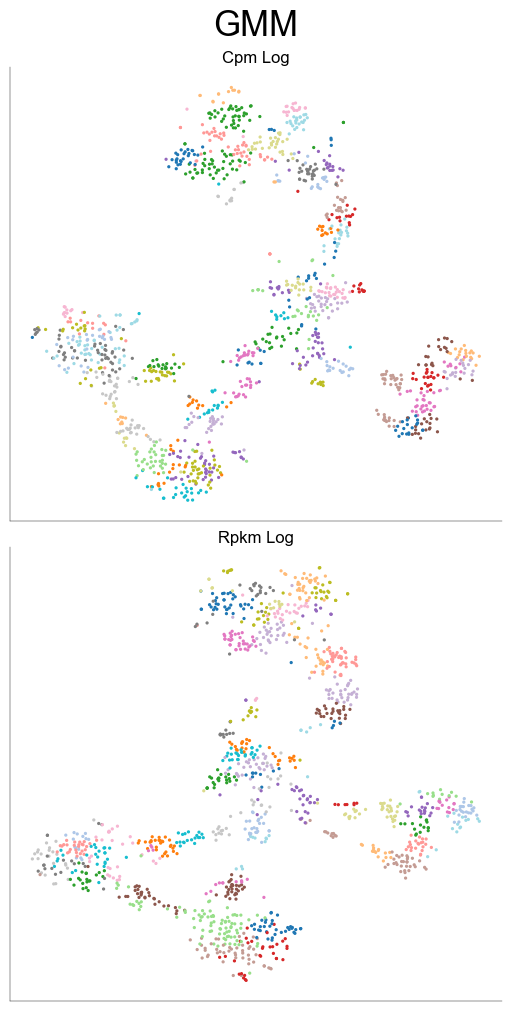

In [121]:
plot_2d_vis(tsne_results, "GMM", gmm_labels)

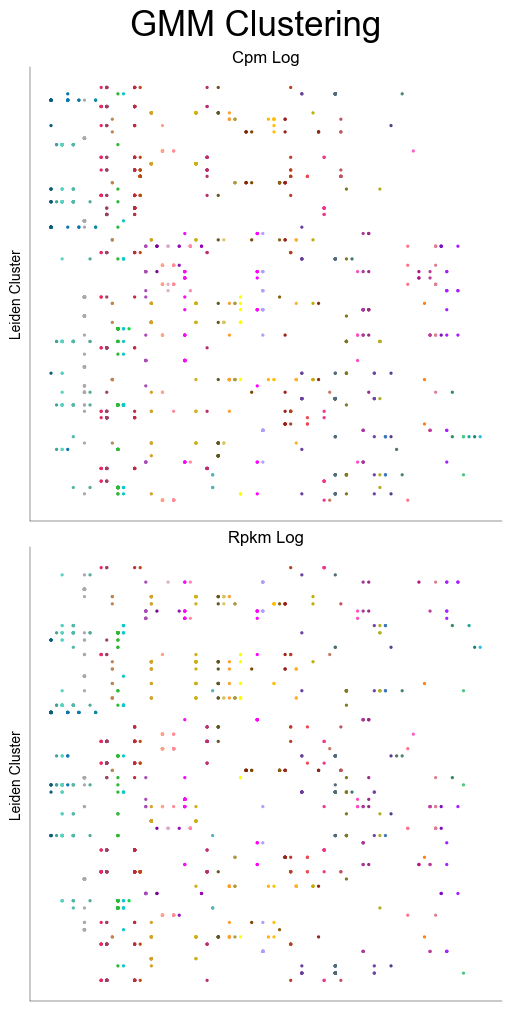

In [124]:
# plot actual categories vs leiden clusters
num_rows = len(gmm_labels.keys())
num_cols = len(list(gmm_labels.values())[0].keys())
fig, axs = plt.subplots(
    num_rows,
    num_cols,
    figsize=(num_cols * 5, num_rows * 5),
)


if axs.ndim == 1:
    axs = axs.reshape(-1, 1)

fig.suptitle("GMM Clustering", fontsize=25)
for i, (norm_key, sub_dict) in enumerate(gmm_labels.items()):
    for j, (trans_key, pca_result) in enumerate(sub_dict.items()):
        axs[i, j].scatter(
            cluster_colors,
            pca_result,
            s=7,
            c=cluster_colors,
        )
        axs[i, j].set_title(f"{norm_key} {trans_key}".title())
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        if i == num_transforms - 1:
            axs[i, j].set_xlabel("GT Cluster")
        if j == 0:
            axs[i, j].set_ylabel("Leiden Cluster")

## 4.4 Negative Binomial Mixture Model

In [41]:
from NBMixture import NBMixture

n_clusters = 10
gmm = NBMixture(n_components=n_clusters, random_state=0)

print(f"Number of clusters: {n_clusters}")
gmm_labels = dict()
for norm_key, sub_dict in pca_results.items():
    gmm_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        gmm_labels[norm_key][trans_key] = gmm.fit_predict(pca_result)

Number of clusters: 10
Checkin parameters
Checkin parameters
Checkin parameters
Checkin parameters
Checkin parameters
Checkin parameters
Checkin parameters
Checkin parameters
Checkin parameters


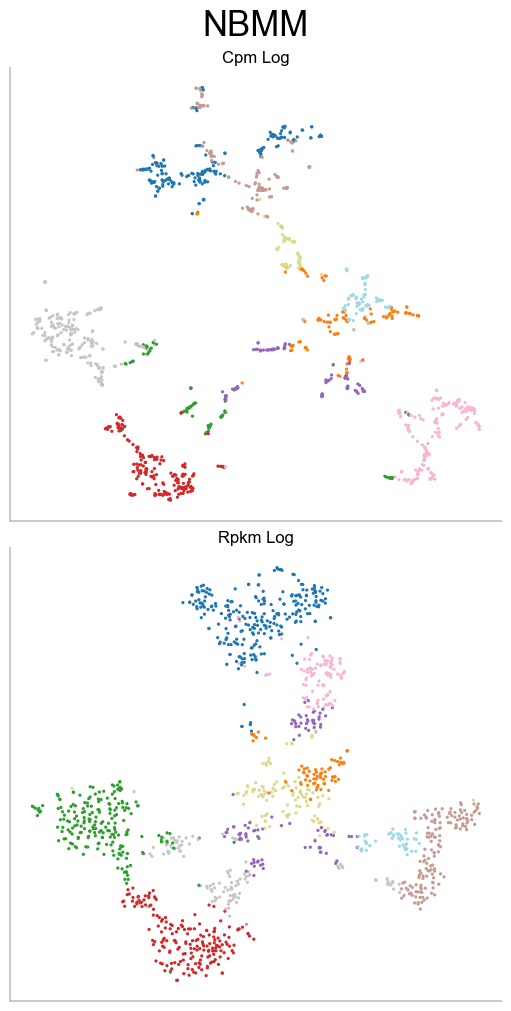

In [45]:
plot_2d_vis(tsne_results, "NBMM", gmm_labels)

# 5. Correlation in between Electrophysiological Features and Genes/PCs

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    